# 🧵 Fashion Dataset AI System
We are developing an AI system using deep learning techniques like Variational Autoencoders (VAE), and Generative Adversarial Networks (GANs) with a Fashion dataset. These models will help in clothing style feature extraction, attribute classification, and synthetic fashion item generation. By leveraging these approaches, we aim to enhance style recognition, denoising, and fashion design prototyping for improved image analysis.

In [13]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [87]:
base_path = r"C:\Users\yasam\Semester5\UnsupervisedLearning\Project\fashion-dataset"
images_file_path = os.path.join(base_path, "images.csv")
images_df = pd.read_csv(images_file_path)

styles_file_path = os.path.join(base_path, "styles.csv")
styles_df = pd.read_csv(styles_file_path, on_bad_lines='skip')


In [88]:
images_df

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...
...,...,...
44441,17036.jpg,http://assets.myntassets.com/v1/images/style/p...
44442,6461.jpg,http://assets.myntassets.com/v1/images/style/p...
44443,18842.jpg,http://assets.myntassets.com/v1/images/style/p...
44444,46694.jpg,http://assets.myntassets.com/v1/images/style/p...


In [105]:
print(images_df.head())
print(styles_df[['id', 'articleType']].head())

    filename                                               link     id
0  15970.jpg  http://assets.myntassets.com/v1/images/style/p...  15970
1  39386.jpg  http://assets.myntassets.com/v1/images/style/p...  39386
2  59263.jpg  http://assets.myntassets.com/v1/images/style/p...  59263
3  21379.jpg  http://assets.myntassets.com/v1/images/style/p...  21379
4  53759.jpg  http://assets.myntassets.com/v1/images/style/p...  53759
      id  articleType
0  15970       Shirts
1  39386        Jeans
2  59263      Watches
3  21379  Track Pants
4  53759      Tshirts


In [106]:
images_df['id'] = images_df['filename'].str.replace('.jpg', '', regex=False).astype(int)
print(images_df['id'].head())
print(filtered_styles['id'].head())

0    15970
1    39386
2    59263
3    21379
4    53759
Name: id, dtype: int32
Series([], Name: id, dtype: int64)


In [108]:
print(images_df['filename'].unique()[:5])

['15970.jpg' '39386.jpg' '59263.jpg' '21379.jpg' '53759.jpg']


In [109]:
images_df['id'] = images_df['filename'].str.extract(r'(\d+)').astype(int)

In [120]:
print(styles_df[['id', 'articleType']].head(10))

      id  articleType
0  15970       Shirts
1  39386        Jeans
2  59263      Watches
3  21379  Track Pants
4  53759      Tshirts
5   1855      Tshirts
6  30805       Shirts
7  26960       Shirts
8  29114        Socks
9  30039      Watches


In [126]:
print(images_df['filename'].head(20))

0     15970.jpg
1     39386.jpg
2     59263.jpg
3     21379.jpg
4     53759.jpg
5      1855.jpg
6     30805.jpg
7     26960.jpg
8     29114.jpg
9     30039.jpg
10     9204.jpg
11    48123.jpg
12    18653.jpg
13    47957.jpg
14    46885.jpg
15    12369.jpg
16    29928.jpg
17    42419.jpg
18    51832.jpg
19    47359.jpg
Name: filename, dtype: object


In [127]:
images_df['id'] = images_df['filename'].str.replace('.jpg', '', regex=False)
print(images_df['id'].head(10))
print(images_df['id'].str.isnumeric().value_counts())

0    15970
1    39386
2    59263
3    21379
4    53759
5     1855
6    30805
7    26960
8    29114
9    30039
Name: id, dtype: object
id
True    44446
Name: count, dtype: int64


In [129]:
print(styles_df['articleType'].value_counts().head(20))

articleType
Tshirts                  7067
Shirts                   3217
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   936
Flip Flops                914
Sandals                   897
Briefs                    849
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Perfume and Body Mist     613
Jeans                     609
Name: count, dtype: int64


# Denoising VAEs Model

In [134]:
# First add noising function

def add_noise(img, noise_factor=0.1):
    """Add random Gaussian noise to images"""
    noise = torch.randn_like(img) * noise_factor
    img_noisy = torch.clamp(img + noise, 0., 1.)
    return img_noisy

In [135]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Sigmoid to output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
def add_noise(img):
    noise = torch.randn_like(img) * 0.1
    img_noisy = torch.clamp(img + noise, 0., 1.)
    return img_noisy

# Training Function for One Epoch 

In [159]:
def main_denoising_fashion(base_path, selected_classes=['Dress', 'Shoes']):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_folder = os.path.join(base_path, "images")

    # Load CSV files
    styles_df = pd.read_csv(os.path.join(base_path, "styles.csv"), on_bad_lines='skip')
    styles_df = styles_df[styles_df['articleType'].isin(selected_classes)].dropna(subset=['id', 'articleType'])

    # Ensure valid int IDs and file paths
    styles_df['id'] = styles_df['id'].astype(str)
    styles_df['filename'] = styles_df['id'].apply(lambda x: x + ".jpg")
    styles_df['image_path'] = styles_df['filename'].apply(lambda x: os.path.join(image_folder, x))
    styles_df = styles_df[styles_df['image_path'].apply(os.path.exists)]

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    # Results
    confusion_mat = np.zeros((len(selected_classes), len(selected_classes)))
    all_train_losses, all_val_losses, all_aurocs, all_thresholds = [], [], [], []

    for i, class_name in enumerate(selected_classes):
        print(f"\nTraining for class: {class_name}")

        # Split data
        class_df = styles_df[styles_df['articleType'] == class_name]
        others_df = styles_df[styles_df['articleType'] != class_name]
        train_df, val_df = train_test_split(class_df, test_size=0.2, random_state=42)

        # Create loaders
        train_set = FashionDatasetFromCSV(train_df, transform)
        val_set = FashionDatasetFromCSV(val_df, transform)
        others_set = FashionDatasetFromCSV(others_df, transform)

        train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
        ano_loader = DataLoader(others_set, batch_size=64, shuffle=False)

        # Model
        model = VanillaAutoencoder(latent_dim=32).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.MSELoss()

        # Training
        train_losses, val_losses = [], []
        for epoch in range(10):
            loss = train_denoising_epoch(model, train_loader, criterion, optimizer, device)
            val_loss = evaluate_model(model, val_loader, criterion, device)
            train_losses.append(loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch+1}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # AUROC & threshold
        auroc = test_model(model, val_loader, [ano_loader], device)
        threshold = select_threshold(model, val_loader, ano_loader, device)
        all_aurocs.append(auroc)
        all_thresholds.append(threshold)

        print(f"AUROC for {class_name}: {auroc:.4f}, Threshold: {threshold:.4f}")

        # Confusion matrix
        real_preds = get_predictions(model, val_loader, threshold, device)
        ano_preds = get_predictions(model, ano_loader, threshold, device)
        confusion_mat[i, i] += np.sum(real_preds == 1)
        for j in range(len(selected_classes)):
            if j != i:
                confusion_mat[i, j] += np.sum(ano_preds == 0)

        # Save model
        os.makedirs('models/denoising_autoencoder', exist_ok=True)
        torch.save(model.state_dict(), f'models/denoising_autoencoder/dae_class_{class_name}.pth')

    return confusion_mat, all_aurocs, all_thresholds, all_train_losses, all_val_losses

# VAE Architecture

In [3]:
class DummyFashionDataset(Dataset):
    def __init__(self, transform=None):
        self.images = [torch.rand(3, 64, 64) for _ in range(100)]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        return img

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)
        self.decoder_input = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(self.decoder_input(z))
        return decoded, mu, logvar

In [5]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [10]:
def train_vae(model, data_loader, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(batch)
            loss = vae_loss(recon, batch, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            print(f"Epoch {epoch}, Loss: {total_loss / len(data_loader):.2f}")

In [11]:
def show_images(images, title=""):
    grid = make_grid(torch.stack(images), nrow=len(images))
    plt.figure(figsize=(10, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

Epoch 0, Loss: 2360.37
Epoch 0, Loss: 4722.91
Epoch 0, Loss: 7080.78
Epoch 0, Loss: 9432.03
Epoch 0, Loss: 11775.66
Epoch 0, Loss: 14122.34
Epoch 0, Loss: 14709.43
Epoch 1, Loss: 2335.35
Epoch 1, Loss: 4678.46
Epoch 1, Loss: 7025.20
Epoch 1, Loss: 9365.92
Epoch 1, Loss: 11709.96
Epoch 1, Loss: 14050.22
Epoch 1, Loss: 14632.49
Epoch 2, Loss: 2343.74
Epoch 2, Loss: 4691.37
Epoch 2, Loss: 7024.79
Epoch 2, Loss: 9358.74
Epoch 2, Loss: 11701.53
Epoch 2, Loss: 14039.09
Epoch 2, Loss: 14624.09
Epoch 3, Loss: 2335.66
Epoch 3, Loss: 4673.92
Epoch 3, Loss: 7010.10
Epoch 3, Loss: 9351.01
Epoch 3, Loss: 11686.62
Epoch 3, Loss: 14030.40
Epoch 3, Loss: 14618.16
Epoch 4, Loss: 2341.52
Epoch 4, Loss: 4682.09
Epoch 4, Loss: 7012.31
Epoch 4, Loss: 9353.72
Epoch 4, Loss: 11691.88
Epoch 4, Loss: 14032.59
Epoch 4, Loss: 14614.25


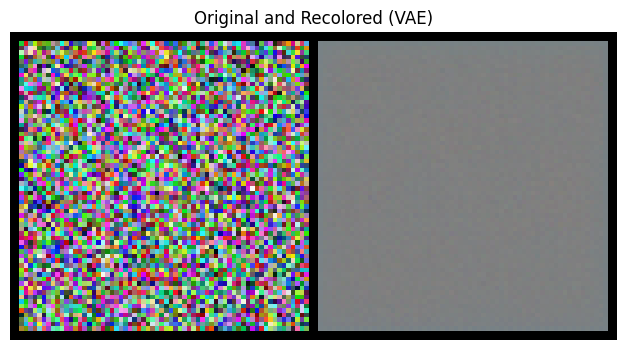

In [17]:
dataset = DummyFashionDataset()
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

vae = VAE(latent_dim=128).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

train_vae(vae, data_loader, optimizer, device, epochs=5)

vae.eval()
test_img = next(iter(data_loader))[0].to(device)  
with torch.no_grad():
    sample = test_img.unsqueeze(0) 
    recon, mu, logvar = vae(sample)
    z = vae.reparameterize(mu, logvar)
    z_recolored = z + torch.randn_like(z) * 0.2
    recolored = vae.decoder(vae.decoder_input(z_recolored))

    show_images([sample.squeeze(0), recolored.squeeze(0)], title="Original and Recolored (VAE)")

In [152]:
def train_denoising_epoch(denoising_autoencoder, train_loader, criterion, optimizer, device):
    denoising_autoencoder.train()
    total_loss = 0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        inputs_noisy = add_noise(inputs) 
        optimizer.zero_grad()
        outputs = denoising_autoencoder(inputs_noisy)  
        loss = criterion(outputs, inputs)  
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader) 

In [147]:
def visualize_denoising_results(model, data_loader, device, n=6):
    model.eval()
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images[:n].to(device)
    
    with torch.no_grad():
        noisy_images = add_noise(images)
        outputs = model(noisy_images)

    images = images.cpu()
    noisy_images = noisy_images.cpu()
    outputs = outputs.cpu()

    fig, axes = plt.subplots(3, n, figsize=(n*2, 6))
    for i in range(n):
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(noisy_images[i].permute(1, 2, 0))
        axes[1, i].set_title("Noisy")
        axes[1, i].axis('off')

        axes[2, i].imshow(outputs[i].permute(1, 2, 0))
        axes[2, i].set_title("Denoised")
        axes[2, i].axis('off')

plt.tight_layout()

plt.show()

<Figure size 640x480 with 0 Axes>